In [127]:
import scanpy as sc
import pandas as pd
import scipy as sp
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
#from convert_adata import anndata_to_csv

import os
from collections import Counter
import sys

sc.set_figure_params(dpi_save=500)
plt.rcParams["axes.grid"] = False
# import loompy

In [1]:
import matplotlib.pyplot as plt

TypeError: float() argument must be a string or a number, not 'dict'

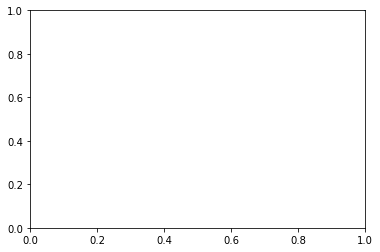

In [8]:
plt.plot([1,2,3], [1,2,3], {'alpha': 0.5 })

In [128]:

working_directory = "/mnt/storage/dati_lucreziap/CONGASp_data/crc"
os.chdir(working_directory)
# s = "I10_1_001_3770_1027_S1"
# sample_list=[s]

In [192]:
patient = 'A015'
tumorNormal = 'normal'

In [193]:
os.system( f"gzip {patient}/{tumorNormal}/rna/matrix.mtx")
os.system( f"gzip {patient}/{tumorNormal}/rna/features.tsv")
os.system( f"gzip {patient}/{tumorNormal}/rna/barcodes.tsv")

0

In [194]:
#all_counts = pd.read_csv("SU/GSE123813_bcc_scRNA_counts.txt.gz", sep='\t', compression='gzip')
adata = sc.read_10x_mtx(f"{patient}/{tumorNormal}/rna")
adata

AnnData object with n_obs × n_vars = 1038 × 33538
    var: 'gene_ids', 'feature_types'

In [195]:
fig_dir = "./QC_figures"
os.makedirs(fig_dir, exist_ok=True)

In [196]:
adata.var

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression
...,...,...
AC233755.2,ENSG00000277856,Gene Expression
AC233755.1,ENSG00000275063,Gene Expression
AC240274.1,ENSG00000271254,Gene Expression
AC213203.1,ENSG00000277475,Gene Expression


In [197]:
def mitochondrial_threshold_identification(adata, plot_name = []):
    """
    Function that performs filtering of cells based on mitochondrial counts fraction.

    Parameters:
    ------
    adata (AnnData): AnnData object with adata.obs column named "gene_symbol"
    plot_name (str, optional): string indicating the name of the plot to save
    ------
    Returns:
    adata: Anndata object filtered based on mitochondrial counts fraction
    saves the scatter plot in the directory "figures/" inside the current working directory
    """
    sc.pp.filter_cells(adata, min_counts = 0)
    sc.pp.filter_cells(adata, min_genes=0)
    sc.pp.filter_genes(adata, min_counts = 0)
    sc.pp.filter_genes(adata, min_cells=0)

    mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
    mt_frac = adata[:, mt_gene_mask].X.sum(1).reshape(adata.shape[0])/adata.obs["n_counts"].values
    adata.obs['mt_frac'] = np.asarray(mt_frac)[0]

    p = plt.scatter(adata.obs['n_counts'], adata.obs['n_genes'], 
                  c=adata.obs["mt_frac"], 
                  s=3, 
                  vmin=0,
                  vmax=1, 
                  cmap=plt.cm.get_cmap("viridis"))
    plt.colorbar(p)
    plt.xlabel("n_counts")
    plt.ylabel("n_genes")
    plt.title("mt fraction")
    plt.tight_layout()
    if plot_name:
        plt.savefig(f"figures/{plot_name}_mitoc_scatter.png", 
                    dpi=500, 
                    bbox_inches="tight")
    plt.show()

    m = np.mean(adata.obs['mt_frac'])
    s = np.std(adata.obs['mt_frac'])
    cut_mitoc = m + s
    print(f"Mitochondrial fraction threshold: {cut_mitoc}")
    
    f,ax = plt.subplots(1,1, figsize=(6,6))
    
    sb.distplot(adata.obs['mt_frac'], kde=False, bins=60, ax=ax)
    
    ax.set_ylabel("Frequency", fontsize=15)
    ax.set_xlabel("Mitochondrial counts fraction", fontsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax.tick_params(axis="x", labelsize=15)
    ax.axvline(cut_mitoc)

    if plot_name:
        plt.savefig(f'./figures/{plot_name}_mitoc_dist.png', 
                    dpi=500, 
                    bbox_inches="tight")
    plt.show()

    #adata = adata[adata.obs['mt_frac'] <= cut_mitoc]

    return [adata, cut_mitoc]

# First load all datasets

In [198]:

sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)
sc.pp.filter_cells(adata, min_counts=0)
sc.pp.filter_genes(adata, min_counts=0)


## Filter cells with more than 90% of zero counts

(0.0, 10000.0)

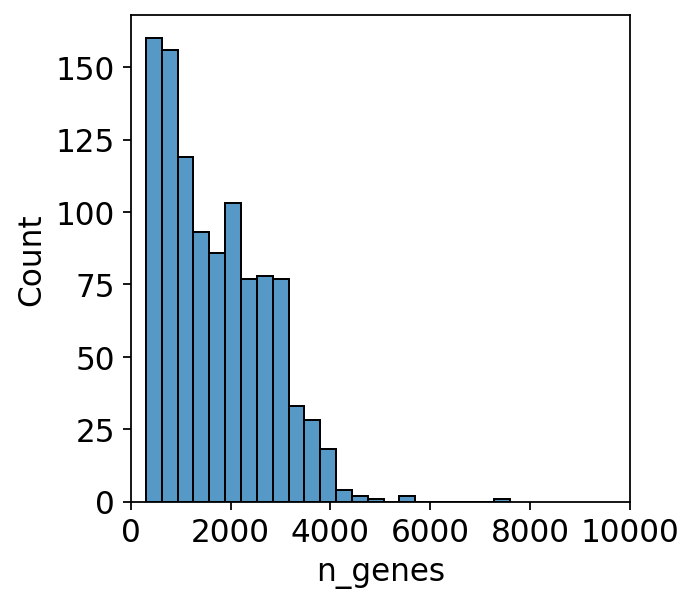

In [199]:
sb.histplot(data = adata.obs, x = 'n_genes')
plt.xlim([0, 10000])

In [200]:
# Use parameters from the paper
print(f"Shape of adata before cell filtering {adata.shape}")
sc.pp.filter_cells(adata, min_genes = 400)
sc.pp.filter_cells(adata, max_genes = 4000)
print(f"Shape of adata after cell filtering {adata.shape}")



Shape of adata before cell filtering (1038, 21400)
Shape of adata after cell filtering (1017, 21400)


## Doublet filtering

In [201]:
doublet_fig = f"{fig_dir}/doublets"
os.makedirs(doublet_fig, exist_ok=True)

<ipython-input-202-8b3382425aaf>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(adata.obs['n_counts'], kde=False, bins=300, ax=ax[0])
<ipython-input-202-8b3382425aaf>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>20000], kde=False, bins=60, ax=ax[1

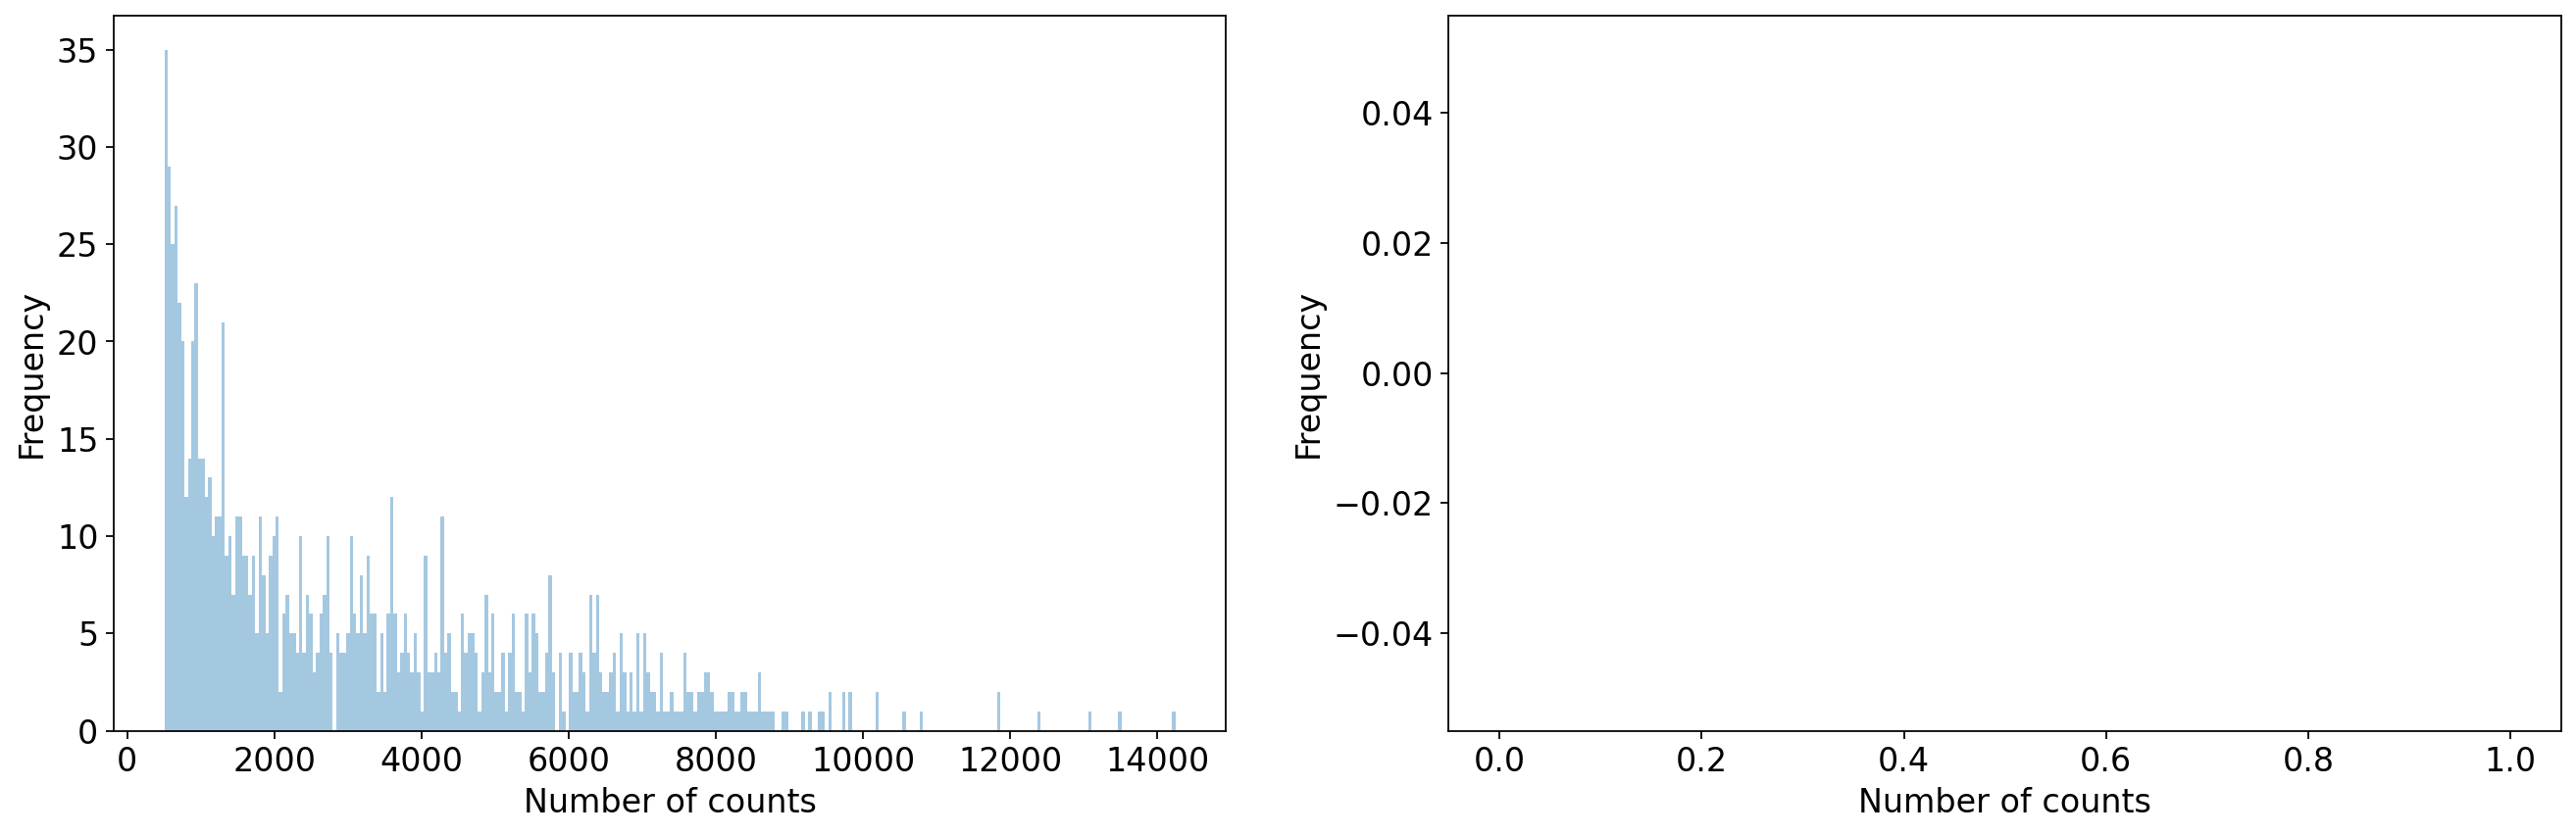

In [202]:

f, ax = plt.subplots(1,2, figsize=(20,6))
sb.distplot(adata.obs['n_counts'], kde=False, bins=300, ax=ax[0])
ax[0].set_ylabel("Frequency", fontsize=15)
ax[0].set_xlabel("Number of counts", fontsize=15)
ax[0].tick_params(axis="y", labelsize=15)
ax[0].tick_params(axis="x", labelsize=15)
#doub_lim = 1e5
#ax[0].axvline(doub_lim)

sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>20000], kde=False, bins=60, ax=ax[1])
ax[1].set_ylabel("Frequency", fontsize=15)
ax[1].set_xlabel("Number of counts", fontsize=15)
ax[1].tick_params(axis="y", labelsize=15)
ax[1].tick_params(axis="x", labelsize=15)
#ax[1].axvline(doub_lim)
plt.savefig(f'{doublet_fig}/counts.pdf')
plt.savefig(f'{doublet_fig}/counts.png', dpi=200)
plt.show()

In [203]:
print(f"Shape of adata before doublet filtering {adata.shape}")
sc.pp.filter_cells(adata, max_counts=6000)
print(f"Shape of adata after doublet filtering {adata.shape}")


Shape of adata before doublet filtering (1017, 21400)
Shape of adata after doublet filtering (858, 21400)


## Mitochondrial fraction filtering

In [204]:
fig_dir

'./QC_figures'

In [205]:
mitoc_dir = f"{fig_dir}/mitochondrial_fraction/"
os.makedirs(mitoc_dir, exist_ok=True)
os.makedirs('figures', exist_ok=True)

Shape of adata before mitoc filtering (858, 21400)


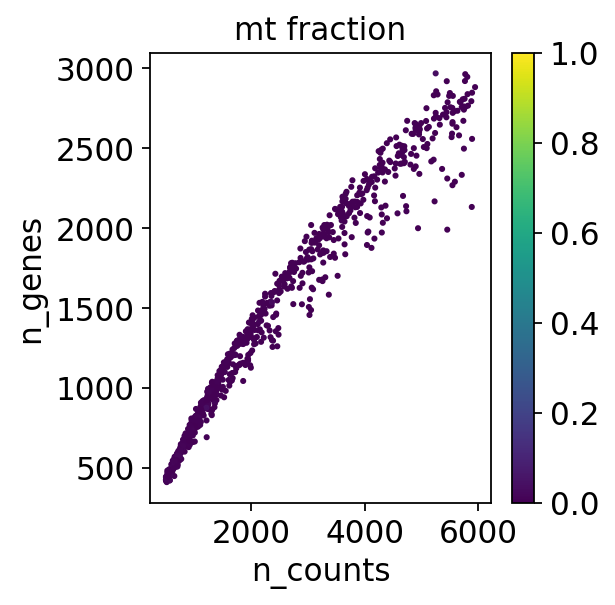

Mitochondrial fraction threshold: 0.009713666047900915


<ipython-input-197-f63cfb651dda>:47: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(adata.obs['mt_frac'], kde=False, bins=60, ax=ax)


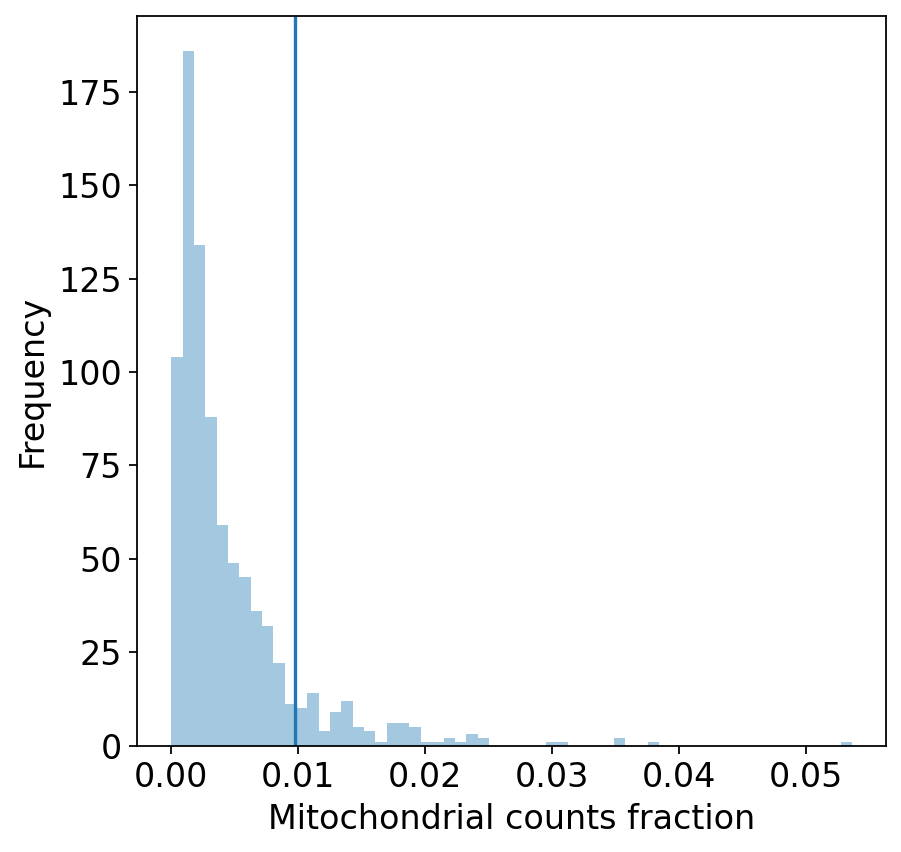

In [206]:

print(f"Shape of adata before mitoc filtering {adata.shape}")
adata, cut_mitoc = mitochondrial_threshold_identification(adata, plot_name=patient)


In [207]:
cut_mitoc

0.009713666047900915

In [208]:
print(adata.shape)
adata = adata[adata.obs['mt_frac'] <= 0.05,:].copy() 
print(adata.shape)

(858, 21400)
(857, 21400)


## Save the result in a .loom file

In [209]:
!pwd 

/mnt/storage/dati_lucreziap/CONGASp_data/crc


In [210]:
adata.write_loom(f"{patient}/{tumorNormal}/rna/filtered_counts.loom")

## Plot UMAP

In [211]:
adata.layers['raw_counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [212]:
sc.pp.pca(adata, n_comps=100, random_state=0)
sc.pp.neighbors(adata, n_pcs=100, n_neighbors=20,random_state=0)
sc.tl.umap(adata, random_state=0)

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

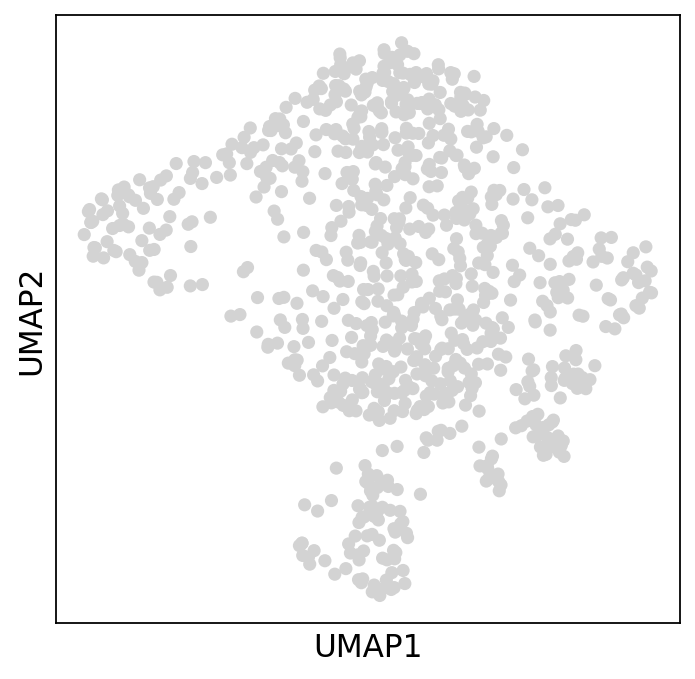

In [213]:
f,ax = plt.subplots(1,1,figsize=(5,5))
sc.pl.umap(adata, show=False, ax=ax)
#plt.savefig(f"{fig_dir}/conc_umap.png",
#           bbox_inches='tight',
#           dpi=200)